<a href="https://colab.research.google.com/github/Shifoue/Segmentation/blob/main/UNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Shifoue/Portfolio.git

Cloning into 'Portfolio'...
remote: Enumerating objects: 4206, done.
remote: Counting objects: 100% (527/527), done.
remote: Compressing objects: 100% (288/288), done.
remote: Total 4206 (delta 242), reused 502 (delta 222), pack-reused 3679
Receiving objects: 100% (4206/4206), 47.76 MiB | 19.04 MiB/s, done.
Resolving deltas: 100% (808/808), done.
Updating files: 100% (5052/5052), done.


In [2]:
!cd Portfolio/Eye_Segmentation_Project/

In [3]:
!pip install utils
!pip install torchmetrics

  Preparing metadata (setup.py) ... done
  Created wheel for utils: filename=utils-1.0.2-py2.py3-none-any.whl size=13906 sha256=24ce2a20cbcf0b6ba29904a41175f35734b43cc70c1a70109814a94de589abfe
  Stored in directory: /root/.cache/pip/wheels/b8/39/f5/9d0ca31dba85773ececf0a7f5469f18810e1c8a8ed9da28ca7
Successfully built utils
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 10.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.w

In [4]:
!unzip Dataset_Faces_training.zip
!unzip Dataset_Faces_validation.zip

!unzip Dataset_Faces_Mask_training.zip
!unzip Dataset_Faces_Mask_validation.zip

unzip:  cannot find or open Dataset_Faces_training.zip, Dataset_Faces_training.zip.zip or Dataset_Faces_training.zip.ZIP.
unzip:  cannot find or open Dataset_Faces_validation.zip, Dataset_Faces_validation.zip.zip or Dataset_Faces_validation.zip.ZIP.
unzip:  cannot find or open Dataset_Faces_Mask_training.zip, Dataset_Faces_Mask_training.zip.zip or Dataset_Faces_Mask_training.zip.ZIP.
unzip:  cannot find or open Dataset_Faces_Mask_validation.zip, Dataset_Faces_Mask_validation.zip.zip or Dataset_Faces_Mask_validation.zip.ZIP.


In [5]:
import torch
import torch.nn as nn

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.depht = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, X):
        return self.depht(X)

class myUNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
      super(myUNET, self).__init__()
      self.encode = nn.ModuleList()
      self.decode = nn.ModuleList()
      self.pool = nn.MaxPool2d(kernel_size=2, stride=2) #divide size per 2

      # Encode
      for feature in features:
          self.encode.append(DoubleConv(in_channels, feature))
          in_channels = feature

      # Decode
      for feature in reversed(features):
          self.decode.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2))
          self.decode.append(DoubleConv(feature*2, feature))

      self.bottleneck = DoubleConv(features[-1], features[-1]*2)
      self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, X):
        skip_connections = []

        for depht in self.encode:
            X = depht(X)
            skip_connections.append(X)
            X = self.pool(X)

        X = self.bottleneck(X)
        skip_connections = skip_connections[::-1]

        for i in range(0, len(self.decode), 2):
            X = self.decode[i](X)
            #skip_connection = skip_connections[-1 - i//2]
            skip_connection = skip_connections[i//2]

            if X.shape != skip_connection.shape:
                X = torch.nn.functional.interpolate(X, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, X), dim=1)
            X = self.decode[i+1](concat_skip)

        return self.final_conv(X)

def test():
    x = torch.randn((3, 1, 160, 160))
    m = myUNET(in_channels=1, out_channels=1)
    pred = m(x)

    assert pred.shape == x.shape

test()

In [6]:
import os
from PIL import Image
from torch.utils.data import Dataset
import numpy as np

In [7]:
class FaceDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)
        self.masks = os.listdir(mask_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.masks[index])
        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L") #, dtype=np.float32)

        #mask[mask == 255.0] = 1.0
        #mask = mask/255.0

        if self.transform is not None:

            #augmentations = self.transform(image=image, mask=mask)
            image = self.transform(image) #augmentations["image"]
            mask = self.transform(mask) #augmentations["mask"]
            mask = (mask > 0.5).float()

        return image, mask

In [8]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [9]:
#Hyperparamters

LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16
NUM_EPOCHS = 50
NUM_WORKERS = 2
IMAGE_HEIGHT = 218
IMAGE_WIDTH = 178
PIN_MEMORY = True
LOAD_MODEL = True
IMG_DIR_TRAIN = "/content/Portfolio/Eye_Segmentation_Project/Dataset_Faces_training"
IMG_DIR_VAL = "/content/Portfolio/Eye_Segmentation_Project/Dataset_Faces_validation"
MASK_DIR_TRAIN = "/content/Portfolio/Eye_Segmentation_Project/Dataset_Faces_Mask_training"
MASK_DIR_VAL = "/content/Portfolio/Eye_Segmentation_Project/Dataset_Faces_Mask_validation"
SAVE_DIR = "Saved_Images"

In [10]:
import cv2

In [11]:
from torch.utils.data import DataLoader

def save_checkpoint(state, filename="checkpoint.pth"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def get_loaders(
    train_dir,
    train_mask_dir,
    val_dir,
    val_mask_dir,
    batch_size,
    train_transform,
    val_transform,
    num_workers=4,
    pin_memory=True
):
    train_data = FaceDataset(image_dir=train_dir, mask_dir=train_mask_dir, transform = train_transform)
    train_loader = DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory, shuffle=True)

    val_data = FaceDataset(image_dir=val_dir, mask_dir=val_mask_dir, transform = val_transform)
    val_loader = DataLoader(val_data, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory, shuffle=False)

    return train_loader, val_loader

def check_accuracy(loader, model, device="cuda"):
    num_correct = 0 #did i predict correctly
    num_pixels = 0 #how many pixel are correct Area accuracy

    #In order to force the algorithm on finding a good solution instead of only putting black pixel to get a good accuracy due to the small size of the target
    dice_score = 0

    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()

            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / ((preds + y).sum() + 1e-8) #calculate the intersection between ground truth and prediction

    print(f"Got {num_correct}/{num_pixels} with accuracy {num_correct/num_pixels*100}:.2f")
    print(f"Dice score {dice_score/len(loader)}")

    model.train()

    return dice_score/len(loader)

def save_predictions_as_imgs(loader, model, folder = SAVE_DIR, device="cuda"):
    if not os.path.exists(folder):
      os.mkdir(folder)

    model.eval()

    for i , (x, y) in enumerate(loader):
        x = x.to(device)
        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            #print(y.shape)
            #print(preds.shape)
            #y = (y > 0.5).float()

            # preds_path = os.path.join(folder, f"pred_{i}.jpg")
            # truth_path = os.path.join(folder, f"truth_{i}.jpg")
            # print(preds_path)
            # print(truth_path)


            #cv2.imwrite(preds_path, preds.cpu().detach().numpy())
            #cv2.imwrite(truth_path, y.cpu().detach().numpy())
            torchvision.utils.save_image(preds, f"{folder}/pred_{i}.jpg")
            torchvision.utils.save_image(y, f"{folder}/truth_{i}.jpg")

In [12]:
def train(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)

    for i_batch, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
        targets = targets.float().unsqueeze(1).to(device=DEVICE)

        with torch.cuda.amp.autocast():
            preds = model(data)
            loss = loss_fn(preds, targets)

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        loop.set_postfix(loss=loss.item())

In [13]:
import torch.nn.functional as F

In [14]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1. - dice

In [15]:
train_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((IMAGE_HEIGHT, IMAGE_WIDTH)),
        #A.Rotate(limit=35, p=1.0),
        #A.HorizontalFlip(p=0.5),
        #A.VerticalFlip(p=0.1),
        #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        #transforms.Grayscale(),
    ]
)

validation_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((IMAGE_HEIGHT, IMAGE_WIDTH)),
    ]
)

UNET = myUNET(in_channels=3, out_channels=1).to(DEVICE) #for multiple classes change out channels to number of classes
#loss_fn = nn.BCEWithLogitsLoss() # for multiple classes use cross entropy

loss_fn = DiceLoss() #Needed to force the NN to chose another strategy than putting every pixel to white
optimizer = optim.Adam(UNET.parameters(), lr=LEARNING_RATE)

train_loader, val_loader = get_loaders(
    IMG_DIR_TRAIN,
    MASK_DIR_TRAIN,
    IMG_DIR_VAL,
    MASK_DIR_VAL,
    BATCH_SIZE,
    train_transform,
    validation_transform,
    NUM_WORKERS,
    PIN_MEMORY
)

scaler = torch.cuda.amp.GradScaler()

old_dice = 0

for epoch in range(NUM_EPOCHS):
    #print(train_loader)
    train(train_loader, UNET, optimizer, loss_fn, scaler)

    checkpoint =  {
        "state_dict": UNET.state_dict(),
        "optimizer": optimizer.state_dict()
    }

    dice_score = check_accuracy(val_loader, UNET, device=DEVICE)

    if old_dice < dice_score :
      save_checkpoint(checkpoint)
      old_dice = dice_score

    save_predictions_as_imgs(val_loader, UNET, folder="/content/Saved_Images", device=DEVICE)

  0%|          | 0/50 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 50/50 [00:14<00:00,  3.43it/s, loss=0.98]


Got 7648305/7760800 with accuracy 98.55046844482422:.2f
Dice score 0.27623623609542847
=> Saving checkpoint


100%|██████████| 50/50 [00:10<00:00,  4.56it/s, loss=0.288]


Got 7747514/7760800 with accuracy 99.82880401611328:.2f
Dice score 0.7116177082061768
=> Saving checkpoint


100%|██████████| 50/50 [00:11<00:00,  4.54it/s, loss=0.217]


Got 7750363/7760800 with accuracy 99.86551666259766:.2f
Dice score 0.7544875741004944
=> Saving checkpoint


100%|██████████| 50/50 [00:11<00:00,  4.54it/s, loss=0.213]


Got 7750290/7760800 with accuracy 99.86457061767578:.2f
Dice score 0.7792351245880127
=> Saving checkpoint


100%|██████████| 50/50 [00:11<00:00,  4.50it/s, loss=0.267]


Got 7751887/7760800 with accuracy 99.88514709472656:.2f
Dice score 0.7905100584030151
=> Saving checkpoint


100%|██████████| 50/50 [00:11<00:00,  4.45it/s, loss=0.222]


Got 7751503/7760800 with accuracy 99.88020324707031:.2f
Dice score 0.7994078993797302
=> Saving checkpoint


100%|██████████| 50/50 [00:11<00:00,  4.45it/s, loss=0.197]


Got 7752855/7760800 with accuracy 99.89762115478516:.2f
Dice score 0.8209949135780334
=> Saving checkpoint


100%|██████████| 50/50 [00:11<00:00,  4.35it/s, loss=0.193]


Got 7753468/7760800 with accuracy 99.905517578125:.2f
Dice score 0.8298905491828918
=> Saving checkpoint


100%|██████████| 50/50 [00:11<00:00,  4.46it/s, loss=0.183]


Got 7752257/7760800 with accuracy 99.8899154663086:.2f
Dice score 0.8264161944389343


100%|██████████| 50/50 [00:11<00:00,  4.47it/s, loss=0.176]


Got 7753523/7760800 with accuracy 99.9062271118164:.2f
Dice score 0.8402523994445801
=> Saving checkpoint


100%|██████████| 50/50 [00:11<00:00,  4.43it/s, loss=0.147]


Got 7753300/7760800 with accuracy 99.90335845947266:.2f
Dice score 0.8179683089256287


100%|██████████| 50/50 [00:11<00:00,  4.44it/s, loss=0.159]


Got 7753333/7760800 with accuracy 99.90377807617188:.2f
Dice score 0.8334044814109802


100%|██████████| 50/50 [00:11<00:00,  4.42it/s, loss=0.121]


Got 7753539/7760800 with accuracy 99.90644073486328:.2f
Dice score 0.8439274430274963
=> Saving checkpoint


100%|██████████| 50/50 [00:11<00:00,  4.42it/s, loss=0.137]


Got 7753909/7760800 with accuracy 99.91120147705078:.2f
Dice score 0.8448635339736938
=> Saving checkpoint


100%|██████████| 50/50 [00:11<00:00,  4.43it/s, loss=0.125]


Got 7753564/7760800 with accuracy 99.9067611694336:.2f
Dice score 0.8447557091712952


100%|██████████| 50/50 [00:11<00:00,  4.42it/s, loss=0.121]


Got 7753752/7760800 with accuracy 99.9091796875:.2f
Dice score 0.8412988185882568


100%|██████████| 50/50 [00:11<00:00,  4.42it/s, loss=0.129]


Got 7753751/7760800 with accuracy 99.90917205810547:.2f
Dice score 0.8466681241989136
=> Saving checkpoint


100%|██████████| 50/50 [00:11<00:00,  4.40it/s, loss=0.111]


Got 7753735/7760800 with accuracy 99.9089584350586:.2f
Dice score 0.8464868068695068


100%|██████████| 50/50 [00:11<00:00,  4.38it/s, loss=0.123]


Got 7753962/7760800 with accuracy 99.9118881225586:.2f
Dice score 0.8467183709144592
=> Saving checkpoint


100%|██████████| 50/50 [00:11<00:00,  4.39it/s, loss=0.107]


Got 7753785/7760800 with accuracy 99.90960693359375:.2f
Dice score 0.8496416211128235
=> Saving checkpoint


100%|██████████| 50/50 [00:11<00:00,  4.41it/s, loss=0.148]


Got 7753525/7760800 with accuracy 99.90625:.2f
Dice score 0.8425486087799072


100%|██████████| 50/50 [00:11<00:00,  4.40it/s, loss=0.0921]


Got 7753992/7760800 with accuracy 99.91227722167969:.2f
Dice score 0.8509712815284729
=> Saving checkpoint


100%|██████████| 50/50 [00:11<00:00,  4.40it/s, loss=0.153]


Got 7753918/7760800 with accuracy 99.91132354736328:.2f
Dice score 0.8399144411087036


100%|██████████| 50/50 [00:11<00:00,  4.39it/s, loss=0.142]


Got 7754039/7760800 with accuracy 99.91287231445312:.2f
Dice score 0.8454684019088745


100%|██████████| 50/50 [00:11<00:00,  4.38it/s, loss=0.116]


Got 7753745/7760800 with accuracy 99.90908813476562:.2f
Dice score 0.8418771624565125


100%|██████████| 50/50 [00:11<00:00,  4.38it/s, loss=0.1]


Got 7753789/7760800 with accuracy 99.90966033935547:.2f
Dice score 0.8350558280944824


100%|██████████| 50/50 [00:11<00:00,  4.39it/s, loss=0.104]


Got 7753741/7760800 with accuracy 99.9090347290039:.2f
Dice score 0.8378851413726807


100%|██████████| 50/50 [00:11<00:00,  4.38it/s, loss=0.129]


Got 7753892/7760800 with accuracy 99.9109878540039:.2f
Dice score 0.8428226113319397


100%|██████████| 50/50 [00:11<00:00,  4.39it/s, loss=0.0875]


Got 7753930/7760800 with accuracy 99.9114761352539:.2f
Dice score 0.8502261638641357


100%|██████████| 50/50 [00:11<00:00,  4.39it/s, loss=0.103]


Got 7753609/7760800 with accuracy 99.90734100341797:.2f
Dice score 0.8401073813438416


100%|██████████| 50/50 [00:11<00:00,  4.40it/s, loss=0.0724]


Got 7754114/7760800 with accuracy 99.91384887695312:.2f
Dice score 0.8440607190132141


100%|██████████| 50/50 [00:11<00:00,  4.37it/s, loss=0.0461]


Got 7753837/7760800 with accuracy 99.9102783203125:.2f
Dice score 0.8460631370544434


100%|██████████| 50/50 [00:11<00:00,  4.39it/s, loss=0.101]


Got 7753958/7760800 with accuracy 99.91183471679688:.2f
Dice score 0.8493395447731018


100%|██████████| 50/50 [00:11<00:00,  4.40it/s, loss=0.0625]


Got 7754056/7760800 with accuracy 99.91309356689453:.2f
Dice score 0.848822832107544


100%|██████████| 50/50 [00:11<00:00,  4.35it/s, loss=0.0665]


Got 7754115/7760800 with accuracy 99.91385650634766:.2f
Dice score 0.8490436673164368


100%|██████████| 50/50 [00:11<00:00,  4.39it/s, loss=0.0674]


Got 7753986/7760800 with accuracy 99.91219329833984:.2f
Dice score 0.8419026732444763


100%|██████████| 50/50 [00:11<00:00,  4.39it/s, loss=0.0454]


Got 7754034/7760800 with accuracy 99.9128189086914:.2f
Dice score 0.8445780277252197


100%|██████████| 50/50 [00:11<00:00,  4.40it/s, loss=0.0538]


Got 7753977/7760800 with accuracy 99.91207885742188:.2f
Dice score 0.8464606404304504


100%|██████████| 50/50 [00:11<00:00,  4.37it/s, loss=0.055]


Got 7754014/7760800 with accuracy 99.91255187988281:.2f
Dice score 0.8450207114219666


100%|██████████| 50/50 [00:11<00:00,  4.39it/s, loss=0.0645]


Got 7753986/7760800 with accuracy 99.91219329833984:.2f
Dice score 0.8487098813056946


100%|██████████| 50/50 [00:11<00:00,  4.39it/s, loss=0.0705]


Got 7753705/7760800 with accuracy 99.9085693359375:.2f
Dice score 0.8329553008079529


100%|██████████| 50/50 [00:11<00:00,  4.38it/s, loss=0.0319]


Got 7754141/7760800 with accuracy 99.91419219970703:.2f
Dice score 0.8497846126556396


100%|██████████| 50/50 [00:11<00:00,  4.40it/s, loss=0.0641]


Got 7754112/7760800 with accuracy 99.913818359375:.2f
Dice score 0.8462971448898315


100%|██████████| 50/50 [00:11<00:00,  4.39it/s, loss=0.0623]


Got 7754023/7760800 with accuracy 99.91267395019531:.2f
Dice score 0.8453021049499512


100%|██████████| 50/50 [00:11<00:00,  4.33it/s, loss=0.0294]


Got 7754135/7760800 with accuracy 99.91411590576172:.2f
Dice score 0.8508919477462769


100%|██████████| 50/50 [00:11<00:00,  4.38it/s, loss=0.0342]


Got 7753992/7760800 with accuracy 99.91227722167969:.2f
Dice score 0.8430540561676025


100%|██████████| 50/50 [00:11<00:00,  4.39it/s, loss=0.0357]


Got 7753869/7760800 with accuracy 99.91069030761719:.2f
Dice score 0.836156964302063


100%|██████████| 50/50 [00:11<00:00,  4.35it/s, loss=0.0378]


Got 7754069/7760800 with accuracy 99.91326141357422:.2f
Dice score 0.847012460231781


100%|██████████| 50/50 [00:11<00:00,  4.40it/s, loss=0.065]


Got 7753655/7760800 with accuracy 99.90792846679688:.2f
Dice score 0.8427389860153198


100%|██████████| 50/50 [00:11<00:00,  4.38it/s, loss=0.051]


Got 7753806/7760800 with accuracy 99.90988159179688:.2f
Dice score 0.8425098061561584


In [16]:
checkpoint = torch.load("/content/checkpoint.pth")

UNET.load_state_dict(checkpoint["state_dict"])

<All keys matched successfully>

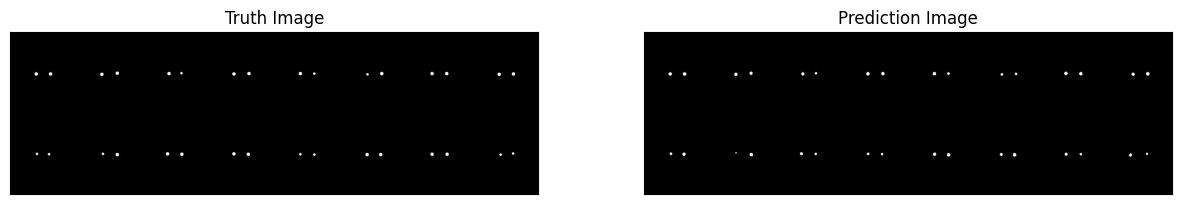

In [17]:
import matplotlib.pyplot as plt

truth_image = Image.open('/content/Saved_Images/truth_0.jpg')
pred_image = Image.open('/content/Saved_Images/pred_0.jpg')


figure_size = 15
plt.figure(figsize=(figure_size,figure_size))
plt.subplot(1,2,1),plt.imshow(truth_image)
plt.title('Truth Image'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2),plt.imshow(pred_image)
plt.title('Prediction Image'), plt.xticks([]), plt.yticks([])
plt.show()